In [1]:
import sys
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt


In [2]:
# Make it possible to import `pallets`

# run from 'pallets/nb'
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
# run from project root
# sys.path.append(os.path.abspath(os.getcwd()))

from pallets import images, datasets, models


In [3]:
# Any GPUs available?

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# The device is passed as an argument to datasets and the training loop


# Prepare Datasets

Create DataLoaders for both:

* the RGBA dataset
* the one-hot encoded dataset

In [4]:
# Unique colors for one punk

image = images.get_punk_tensor(0)
print(f"image shape: {image.shape}\n")

colors = images.one_image_colors(image)
print(f"total colors: {len(colors)}\n")
print(f"image colors:\n{colors}")


image shape: torch.Size([4, 24, 24])

total colors: 7

image colors:
tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000],
        [0.3137, 0.4863, 0.2000, 1.0000],
        [0.3647, 0.5451, 0.2627, 1.0000],
        [0.3725, 0.1137, 0.0353, 1.0000],
        [0.6824, 0.5451, 0.3804, 1.0000],
        [1.0000, 0.9647, 0.5569, 1.0000]])


### RGBA Dataset

In [5]:
# RGBA Dataset

dataset = datasets.CPunksDataset(device, test_size=2000)
print(f"dataset size:   {len(dataset)}")
print(f"  - train size: {len(dataset.train_idx)}")
print(f"  - test size:  {len(dataset.test_idx)}\n")

train_sampler = SubsetRandomSampler(dataset.train_idx)
print(f"train sampler:  {len(train_sampler)}")
print(f"  - sample id:  {next(iter(train_sampler))}\n")

test_sampler = SubsetRandomSampler(dataset.test_idx)
print(f"test sampler:   {len(test_sampler)}")
print(f"  - sample id:  {next(iter(test_sampler))}\n")

rgba_ds = (dataset, train_sampler, test_sampler)



dataset size:   10000
  - train size: 8000
  - test size:  2000

train sampler:  8000
  - sample id:  614

test sampler:   2000
  - sample id:  9841



### One Hot Dataset

1. Generate a one hot representation for all 222 colors.

2. Instantiate a mapper to go from each color to its one hot representation and back.

3. Create dataloader for punks that represents its color data as one hot vectors.

In [6]:
# Unique colors for all punks

all_colors = images.get_punk_colors()
print(f"colors found: {len(all_colors)}")


colors found: 222


In [7]:
# Mapper from color to one hot

mapper = datasets.ColorOneHotMapper(all_colors)

# Start with a color
test_color = all_colors[2]
print(f"color:\n{test_color}\n")

# Convert color to one hot
test_one_hot = mapper.to_one_hot(test_color)
print(f"one-hot encoding:\n{test_one_hot}\n")

# Convert one hot back to original color
retrieved_color = mapper.to_color(test_one_hot)
print(f"retrieved color:\n{retrieved_color}")


color:
tensor([0.0000, 0.2510, 1.0000, 1.0000])

one-hot encoding:
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

one hot encoded: torch.Size([222, 24, 24])
rgba encoded: torch.Size([222, 24, 24])


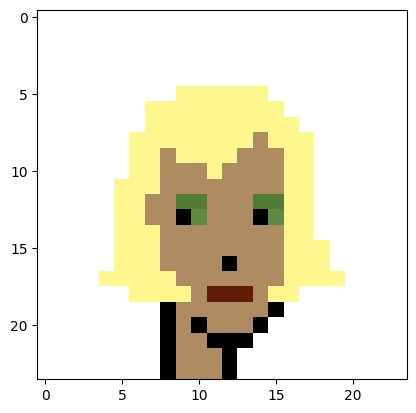

In [8]:
# Convert entire image to one hot encoded and back

one_hot_encoded_image = datasets.rgba_to_one_hot(image, mapper)
print(f"one hot encoded: {one_hot_encoded_image.shape}")

restored = datasets.one_hot_to_rgba(one_hot_encoded_image, mapper)
print(f"rgba encoded: {one_hot_encoded_image.shape}")

# Show an image after going to one hot encoding and back
plt.imshow(to_pil_image(restored))
plt.show()


In [9]:
# One Hot Dataset

dataset = datasets.OneHotEncodedImageDataset(mapper, device=device, test_size=2000)
print(f"dataset size:   {len(dataset)}")
print(f"  - train size: {len(dataset.train_idx)}")
print(f"  - test size:  {len(dataset.test_idx)}\n")

train_sampler = SubsetRandomSampler(dataset.train_idx)
print(f"train sampler:  {len(train_sampler)}")
print(f"  - sample id:  {next(iter(train_sampler))}\n")

test_sampler = SubsetRandomSampler(dataset.test_idx)
print(f"test sampler:   {len(test_sampler)}")
print(f"  - sample id:  {next(iter(test_sampler))}\n")

one_hot_ds = (dataset, train_sampler, test_sampler)


dataset size:   10000
  - train size: 8000
  - test size:  2000

train sampler:  8000
  - sample id:  8947

test sampler:   2000
  - sample id:  8138



# Train Model

In [10]:
# Model: Naive RGBA
# autoencoder = models.NaiveRGBAAutoencoder()
# criterion = torch.nn.MSELoss()
# (dataset, train_sampler, test_sampler) = rgba_ds

# Model: Naive One Hot
# autoencoder = models.NaiveOneHotAutoencoder()
# criterion = torch.nn.CrossEntropyLoss()
# (dataset, train_sampler, test_sampler) = one_hot_ds

# Model: Conv RGBA
# autoencoder = models.ConvRGBAutoencoder()
# criterion = torch.nn.MSELoss()
# (dataset, train_sampler, test_sampler) = rgba_ds

# Model: Conv One Hot
autoencoder = models.ConvOneHotAutoencoder()
criterion = torch.nn.CrossEntropyLoss()
(dataset, train_sampler, test_sampler) = one_hot_ds


In [11]:
# Prepare dataset

batch_size = 32

train_loader = DataLoader(
    dataset, batch_size=batch_size, sampler=train_sampler,
)

test_loader = DataLoader(
    dataset, batch_size=batch_size, sampler=test_sampler,
)

train_punk = next(iter(train_loader))
print(f"train punk: {train_punk.shape}")

test_punk = next(iter(test_loader))
print(f"test punk:  {test_punk.shape}")


train punk: torch.Size([32, 222, 24, 24])
test punk:  torch.Size([32, 222, 24, 24])


In [12]:
# Cue training montage

train_losses, test_losses = models.train(
    device, autoencoder, criterion, train_loader, test_loader,
    learn_rate=1e-3, epochs=5
)


epoch [1/5]
  - train loss: 1.0658789358735083
  - test loss:  0.27171630400513846
epoch [2/5]
  - train loss: 0.122899569272995
  - test loss:  0.04828251407496513
epoch [3/5]
  - train loss: 0.027568459764122963
  - test loss:  0.015275772587056197
epoch [4/5]
  - train loss: 0.010917236240580677
  - test loss:  0.006967080502016913
epoch [5/5]
  - train loss: 0.004821622342802584
  - test loss:  0.004180638829157466


In [21]:
# models.save(autoencoder, 'conv-onehot.pkl')


# Model Output to Image

In [14]:
# autoencoder = models.load('naive-onehot.pkl')
# autoencoder.to(torch.device("cuda"))


In [15]:
# Reconstruct `train_punk`

print(train_punk.shape)

# one_hot_encoded_image = datasets.rgb_to_one_hot(train_punk, mapper)
reconstructed = autoencoder(train_punk)
print(reconstructed.shape)
image_batch = reconstructed.detach().cpu()
some_image = image_batch[0]

print(some_image.shape)
print(some_image)


torch.Size([32, 222, 24, 24])
torch.Size([32, 222, 24, 24])
torch.Size([222, 24, 24])
tensor([[[ 8.0636e+00,  1.0900e+01,  1.7692e+01,  ...,  1.7535e+01,
           1.0026e+01,  6.9687e+00],
         [ 1.3061e+01,  7.5353e+00,  1.0904e+01,  ...,  3.0217e+00,
          -1.3288e+00,  4.1719e+00],
         [ 2.0598e+01,  1.5711e+01,  2.9390e+01,  ...,  1.8563e+01,
          -2.3070e+00,  1.0658e+01],
         ...,
         [ 1.7447e+01,  2.0553e+01,  4.1661e+01,  ...,  4.7256e+01,
           6.7836e+00,  1.3980e+01],
         [ 1.0346e+01,  1.6573e+01,  2.6100e+01,  ...,  2.5657e+01,
           6.2422e+00,  6.9865e+00],
         [ 7.7797e+00,  1.2768e+01,  2.0984e+01,  ...,  2.2011e+01,
           1.0711e+01,  8.0417e+00]],

        [[-3.0735e-01, -3.7643e+00, -9.7567e+00,  ..., -1.9569e+01,
          -1.4723e+01, -4.9595e+00],
         [-2.1037e-01, -9.6635e-01, -9.5213e+00,  ..., -1.7094e+01,
          -9.7276e+00, -7.5958e+00],
         [ 5.0642e-01, -3.6142e+00,  3.8906e+00,  ...,  3.

In [16]:
# From one hot back to 24x24 image with RGBA colors
one_hot_models = (models.ConvOneHotAutoencoder, models.NaiveOneHotAutoencoder)
if isinstance(autoencoder, one_hot_models):
    some_image = datasets.one_hot_to_rgba(some_image, mapper)
    print(some_image.shape)


torch.Size([4, 24, 24])


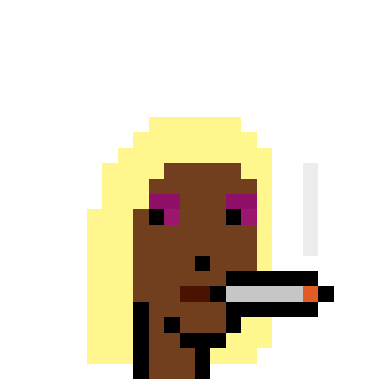

In [17]:
pil_image = to_pil_image(some_image.clone().detach())

plt.imshow(pil_image)
plt.axis('off')
plt.show()



# Tests

In [18]:
train_losses


[1.0658789358735083,
 0.122899569272995,
 0.027568459764122963,
 0.010917236240580677,
 0.004821622342802584]

In [19]:
test_losses


[0.27171630400513846,
 0.04828251407496513,
 0.015275772587056197,
 0.006967080502016913,
 0.004180638829157466]

<function matplotlib.pyplot.show(close=None, block=None)>

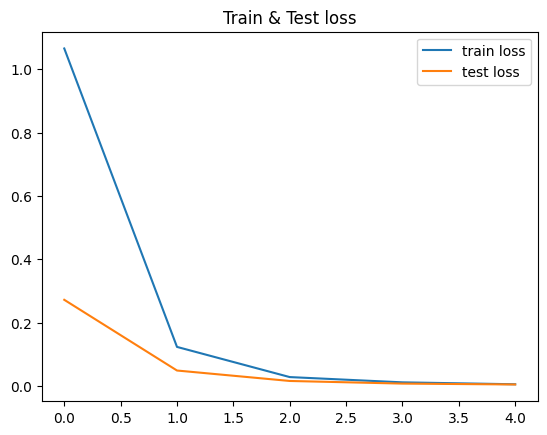

In [20]:
# plt.figure(figsize=(10,5))
plt.title("Train & Test loss")
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show
